# Chain-of-Thought Reasoning (CoT)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import re
import torch

from transformers import T5Tokenizer, T5ForConditionalGeneration 
from datasets import load_dataset
from tqdm.auto import tqdm
from collections import Counter

### 4.1 - Downloading model from HuggingFace

In [3]:
model_name = "google/flan-t5-base"


In [4]:
#load the tokenizer from pretrained model
tokenizer = T5Tokenizer.from_pretrained(model_name)
# Load model
model = T5ForConditionalGeneration.from_pretrained(model_name) #the transformer model


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

### 4.2 - Loading and formatting

In [ ]:
dataset = load_dataset("tasksource/ScienceQA_text_only", split="train")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-a31a321e61f8f5(…):   0%|          | 0.00/1.73M [00:00<?, ?B/s]

data/validation-00000-of-00001-0d4b3eeed(…):   0%|          | 0.00/576k [00:00<?, ?B/s]

data/test-00000-of-00001-60817eb9b00359a(…):   0%|          | 0.00/619k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6508 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2144 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2224 [00:00<?, ? examples/s]

In [6]:
#only include samples with 4 choices form the dataset
dataset_4 = dataset.filter(lambda x: len(x["choices"]) == 4)
#print(dataset_4)


random.seed(42)  #it is the answer to life, the universe and everything XD
sampled = random.sample(list(dataset_4), 200)


def format_question(example):
    question = example["question"]
    choices = example["choices"]

    return (
        f"Question: {question}\n"
        f"Options:\n"
        f"(A) {choices[0]}\n"
        f"(B) {choices[1]}\n"
        f"(C) {choices[2]}\n"
        f"(D) {choices[3]}\n"
    )

formatted_questions = [format_question(q) for q in sampled] #for all 200 samples
formatted_questions[0:5] #vizualize first 5 formatted questions

Filter:   0%|          | 0/6508 [00:00<?, ? examples/s]

['Question: Select the amphibian.\nOptions:\n(A) wombat\n(B) barn owl\n(C) helmeted iguana\n(D) African bullfrog\n',
 'Question: How long is a parking space?\nOptions:\n(A) 20 inches\n(B) 20 miles\n(C) 20 yards\n(D) 20 feet\n',
 'Question: Which type of sentence is this?\nAisha is a competitive horseback rider, and she will be competing in the next World Equestrian Games, which are held every four years.\nOptions:\n(A) complex\n(B) compound-complex\n(C) simple\n(D) compound\n',
 'Question: How long is a long-distance running race?\nOptions:\n(A) 22 kilometers\n(B) 22 meters\n(C) 22 millimeters\n(D) 22 centimeters\n',
 'Question: What is Thurgood Marshall best known for?\nOptions:\n(A) leading civil rights marches in the South\n(B) becoming the first African American member of Congress\n(C) being the first African American justice on the Supreme Court\n(D) helping enslaved people in the South escape to freedom\n']

### 4.3 - The baseline

In [7]:
#the structure of the baseline prompt
def make_baseline_prompt(formatted_q: str) -> str:
    return formatted_q + "Answer:"

baseline_prompts = [make_baseline_prompt(q) for q in formatted_questions]
print(baseline_prompts[0])



#predict function
LETTER_RE = re.compile(r"\b([ABCD])\b")

def predict_letter(prompt: str, model, tokenizer, max_new_tokens: int = 5) -> str:
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False
        )

    text = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
    m = LETTER_RE.search(text)
    return m.group(1) if m else "INVALID" #if no letter found then return INVALID


#run baseline on all questions
model.eval()
torch.set_num_threads(1)

baseline_predictions = []

for prompt in tqdm(baseline_prompts, desc="Baseline (no CoT)"):
    pred = predict_letter(prompt, model, tokenizer)
    baseline_predictions.append(pred)

#show first 5 results
for i in range(5):
    print(f"Q{i}: {baseline_predictions[i]}")


Question: Select the amphibian.
Options:
(A) wombat
(B) barn owl
(C) helmeted iguana
(D) African bullfrog
Answer:


Baseline (no CoT):   0%|          | 0/200 [00:00<?, ?it/s]

Q0: INVALID
Q1: A
Q2: A
Q3: INVALID
Q4: C


### 4.4 - Use of CoT

In [8]:
#our CoT instruction
COT_INSTR = (
    "You are a careful reasoning assistant.\n"
    "Think through the problem step by step.\n"
    "Write three short reasoning steps.\n"
    "Then, output the final answer as a single letter (A–D) on its own line.\n\n"
)

def make_cot_prompt(formatted_q: str) -> str:
    return COT_INSTR + formatted_q.strip() + "\n"

#parsing
LETTER_RE = re.compile(r"\b([ABCD])\b")

torch.set_num_threads(1)
device = torch.device("cpu")
model.to(device)
model.eval()

@torch.no_grad()
def generate_text(prompt: str, max_new_tokens: int = 120) -> str:
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=512
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    out = model.generate(
        **inputs,
        do_sample=False,          #greedy decoding
        max_new_tokens=max_new_tokens,
    )

    return tokenizer.decode(out[0], skip_special_tokens=True).strip()

def parse_output(text: str):
    lines = [l.strip() for l in text.split("\n") if l.strip()]

    # reasoning = everything except last line
    reasoning = lines[:-1][:3]
    while len(reasoning) < 3:
        reasoning.append("")

    #final answer = last detectable letter
    m = LETTER_RE.findall(text)
    answer = m[-1] if m else "INVALID"

    return reasoning[0], reasoning[1], reasoning[2], answer

#run CoT
rows = []
invalid_count = 0

for q in tqdm(formatted_questions, desc="Running CoT prompts (T5-base)"):
    prompt = make_cot_prompt(q)
    out_text = generate_text(prompt)

    r1, r2, r3, ans = parse_output(out_text)
    if ans == "INVALID":
        invalid_count += 1

    rows.append({
        "prompt": prompt,
        "output": out_text,
        "reason1": r1,
        "reason2": r2,
        "reason3": r3,
        "pred_cot": ans
    })

cot_df = pd.DataFrame(rows)

#visualization
print(f"INVALID rate: {invalid_count / len(cot_df) * 100:.1f}%")
print("First 5 predicted letters:", cot_df["pred_cot"].head(5).tolist())
print("\nExample output (first item):")
print(cot_df.loc[0, "output"])


Running CoT prompts (T5-base):   0%|          | 0/200 [00:00<?, ?it/s]

INVALID rate: 1.5%
First 5 predicted letters: ['D', 'D', 'A', 'C', 'B']

Example output (first item):
A wombat is an amphibian. Wombats are amphibians. The final answer: (D).


### 4.5 - Flip analysis

Counts by category:
  Flip-to-correct: 43
  Flip-to-incorrect: 16
  Correct–Correct: 48
  Incorrect–Incorrect: 93

Accuracy (no CoT):  32.0%
Accuracy (with CoT): 45.5%


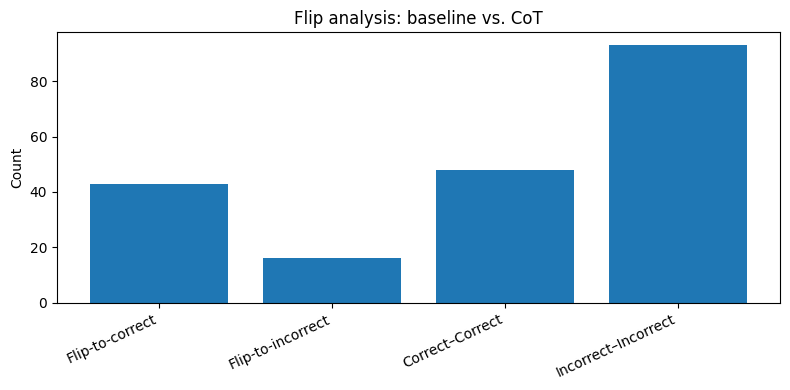

,gold,pred_baseline,pred_cot,category,cot_reason1,cot_reason2,cot_reason3,cot_output
0,D,INVALID,D,Flip-to-correct,,,,A wombat is an amphibian. Wombats are amphibia...
1,D,A,D,Flip-to-correct,,,,A: 20 inches; C: 20 yards; D: 20 feet
2,B,A,A,Incorrect–Incorrect,,,,"Aisha is a competitive horseback rider, and sh..."
3,A,INVALID,C,Incorrect–Incorrect,,,,A: 22 km B: 22 kmph C: 22 kmph
4,C,C,B,Flip-to-incorrect,,,,A: Thurgood Marshall was the first African Ame...


In [9]:
#building gold answers (A–D)
IDX2LETTER = {0: "A", 1: "B", 2: "C", 3: "D"}
gold_answers = [IDX2LETTER[int(ex["answer"])] for ex in sampled]  # length 200


baseline_preds = baseline_predictions                      # from Task 4.3
cot_preds = cot_df["pred_cot"].tolist()                    # from Task 4.4

assert len(gold_answers) == len(baseline_preds) == len(cot_preds), "Lengths don't match."

#INVALID must be treated as incorrect automatically
def is_correct(pred, gold):
    return pred in ["A","B","C","D"] and pred == gold

#categorizing the flips
categories = []
for g, b, c in zip(gold_answers, baseline_preds, cot_preds):
    b_ok = is_correct(b, g)
    c_ok = is_correct(c, g)

    if (not b_ok) and c_ok:
        categories.append("Flip-to-correct")
    elif b_ok and (not c_ok):
        categories.append("Flip-to-incorrect")
    elif b_ok and c_ok:
        categories.append("Correct–Correct")
    else:
        categories.append("Incorrect–Incorrect")

counts = Counter(categories)

#accuracies
baseline_acc = np.mean([is_correct(b, g) for g, b in zip(gold_answers, baseline_preds)])
cot_acc = np.mean([is_correct(c, g) for g, c in zip(gold_answers, cot_preds)])

print("Counts by category:")
for k in ["Flip-to-correct", "Flip-to-incorrect", "Correct–Correct", "Incorrect–Incorrect"]:
    print(f"  {k}: {counts.get(k, 0)}")

print(f"\nAccuracy (no CoT):  {baseline_acc*100:.1f}%")
print(f"Accuracy (with CoT): {cot_acc*100:.1f}%")

#the Bar plot
labels = ["Flip-to-correct", "Flip-to-incorrect", "Correct–Correct", "Incorrect–Incorrect"]
values = [counts.get(k, 0) for k in labels]

plt.figure(figsize=(8,4))
plt.bar(labels, values)
plt.xticks(rotation=25, ha="right")
plt.ylabel("Count")
plt.title("Flip analysis: baseline vs. CoT")
plt.tight_layout()
plt.show()



flip_df = pd.DataFrame({
    "gold": gold_answers,
    "pred_baseline": baseline_preds,
    "pred_cot": cot_preds,
    "category": categories,
    "cot_reason1": cot_df["reason1"],
    "cot_reason2": cot_df["reason2"],
    "cot_reason3": cot_df["reason3"],
    "cot_output": cot_df["output"],
})
flip_df.head()


### 4.6 - Qualitative inspection

In [11]:
#Just to be more clear
categories = labels

def sample_and_print(df, category, n=20, seed=42):
    subset = df[df["category"] == category]
    k = min(n, len(subset))

    print("\n" + "="*90)
    print(f"{category}  |  showing {k} of {len(subset)}")
    print("="*90)

    if k == 0:
        print("(No examples in this category.)")
        return subset

    sampled = subset.sample(n=k, random_state=seed).reset_index(drop=True)

    for i, row in sampled.iterrows():
        print("\n" + "-"*90)
        print(f"[{i+1}/{k}]  gold={row['gold']}  "
              f"baseline={row['pred_baseline']}  CoT={row['pred_cot']}")

        print("\nCoT reasoning steps:")
        print(f"1) {row['cot_reason1']}")
        print(f"2) {row['cot_reason2']}")
        print(f"3) {row['cot_reason3']}")

        print("\nRAW CoT OUTPUT:")
        print(row["cot_output"])

    return sampled


samples = {}
for cat in categories:
    samples[cat] = sample_and_print(flip_df, cat, n=20, seed=42)



Flip-to-correct  |  showing 20 of 43

------------------------------------------------------------------------------------------
[1/20]  gold=D  baseline=A  CoT=D

CoT reasoning steps:
1) 
2) 
3) 

RAW CoT OUTPUT:
A: The old chair was rickety and rickety. The final answer: (D).

------------------------------------------------------------------------------------------
[2/20]  gold=D  baseline=INVALID  CoT=D

CoT reasoning steps:
1) 
2) 
3) 

RAW CoT OUTPUT:
A passenger airplane is 200 feet long. The final answer: (D).

------------------------------------------------------------------------------------------
[3/20]  gold=D  baseline=INVALID  CoT=D

CoT reasoning steps:
1) 
2) 
3) 

RAW CoT OUTPUT:
Brain controls the function of other body organs. The final answer: (D).

------------------------------------------------------------------------------------------
[4/20]  gold=B  baseline=A  CoT=B

CoT reasoning steps:
1) 
2) 
3) 

RAW CoT OUTPUT:
Step1: Walter always approaches difficult 